In [2]:
#Settings
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib

#乱数の固定
import os
import random
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#ベースモデル
BASE_MODEL="VGG16"

#バッチサイズと画像サイズの設定
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

#読み込むデータのディレクトリを指定（このフォルダの下に分類ごとにフォルダ分けして保存してあること）
data_root = pathlib.Path("./Image/Fruits")
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [10]:
#Load Data as dataset
# Train:Validation:Test = 7:1.5:1.5

ValidateionSplitRate=0.3

train_dataset=image_dataset_from_directory(
    data_root , labels='inferred', label_mode='categorical',#intの場合、モデルにはloss='sparse_categorical_crossentropy'を設定する。別のcategoricalはダメ。
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE,
     shuffle=True, seed=SEED, validation_split=ValidateionSplitRate, subset="training",#これがトレーニング用であることを示す
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
validation_dataset=image_dataset_from_directory(
    data_root , labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE,
     shuffle=True, seed=SEED, validation_split=ValidateionSplitRate, subset="validation",#これがValidation用であることを示す
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
class_names = train_dataset.class_names
print("class_names=",class_names)

Found 759 files belonging to 5 classes.
Using 532 files for training.
Found 759 files belonging to 5 classes.
Using 227 files for validation.
class_names= ['apple_braeburn', 'apple_golden_delicious', 'apple_topaz', 'peach', 'pear']


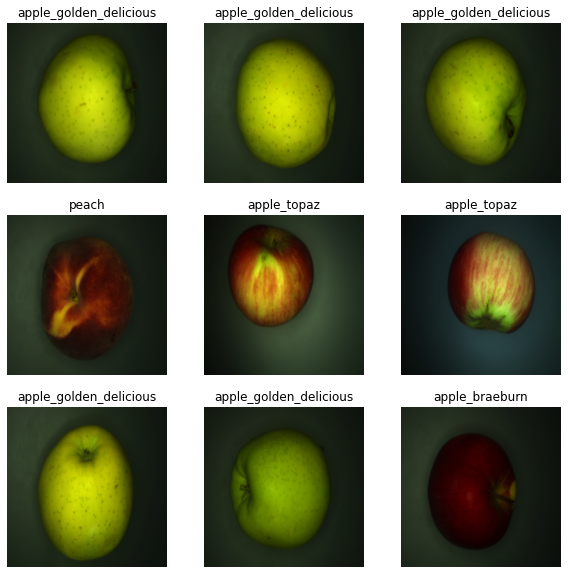

In [11]:
plt.figure(figsize=(10, 10))
for element in train_dataset.as_numpy_iterator():#データセットはバッチサイズを1単位としてラベルと画像が入っているので、.take(1)とすると1つ目のバッチを取り出すことになる
    images=element[0]
    labels=element[1]
    for i in range(9):#バッチにはバッチサイズ分の数の画像とラベルが入っている。最初の9枚分を見せている
        #print(labels)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        class_id=np.argmax(labels, axis=1)
        plt.title(class_names[class_id[i]])
        plt.axis("off")

In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 4


パフォーマンスのためにデータセットを構成する

バッファ付きプリフェッチを使用して、I/O のブロッキングなしでディスクから画像を読み込みます。この手法の詳細についてはデータパフォーマンスガイドをご覧ください。

In [14]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

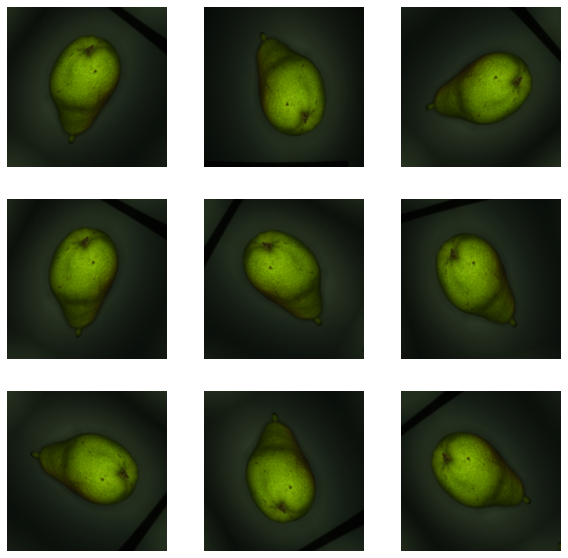

In [16]:
#Check
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [17]:
#Model setting
preprocess_input = tf.keras.applications.vgg16.preprocess_input
inputs = tf.keras.Input(shape=(IMG_SHAPE))#入力Tensor
inputs=data_augmentation(inputs)
inputs = preprocess_input(inputs)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                   include_top=False,
                                   weights='imagenet',
                                   classes = len(class_names), input_tensor=inputs)
base_model.trainable=False

58900480/58889256 [==============================] - 18s 0us/step


In [18]:
last_layer=base_model.layers[-1]#-1で末尾を取り出せる
#print(last_layer.output_shape)
last_layer_outputshape=last_layer.output_shape
dense_unit_to_set=last_layer_outputshape[-1]#-1で末尾を取り出せる
#print("Set this unit=", dense_unit_to_set)

x=base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(dense_unit_to_set,activation='relu')(x)#入力パラメータ数(ベースの一番最後の行？）と隠れ層

prediction_layer = tf.keras.layers.Dense(len(class_names),activation="softmax")#SpareでもCategoricalでも、Softmaxにしたら確率出るようだ（合計１）    
x = prediction_layer(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
    

In [21]:
#パラメータの設定
base_learning_rate = 0.0001
batch_size= BATCH_SIZE
momentum_usage=0.99
initial_epochs = 50

sgd=tf.keras.optimizers.SGD(learning_rate=base_learning_rate,momentum=momentum_usage)
model.compile(optimizer=sgd,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
print("Trainable vals=",len(model.trainable_variables) )
print(model.summary())

Trainable vals= 4
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.add (TFOpLambda)     (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 11

In [22]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
17/17 [==============================] - 4s 162ms/step - loss: 0.7162 - accuracy: 0.7876 - val_loss: 0.2712 - val_accuracy: 0.8889
Epoch 2/50
17/17 [==============================] - 3s 152ms/step - loss: 0.5597 - accuracy: 0.8083 - val_loss: 0.6485 - val_accuracy: 0.7273
Epoch 3/50
17/17 [==============================] - 3s 151ms/step - loss: 0.4779 - accuracy: 0.8271 - val_loss: 0.2814 - val_accuracy: 0.8788
Epoch 4/50
17/17 [==============================] - 3s 153ms/step - loss: 0.4570 - accuracy: 0.8233 - val_loss: 0.2594 - val_accuracy: 0.8889
Epoch 5/50
17/17 [==============================] - 3s 152ms/step - loss: 0.3735 - accuracy: 0.8703 - val_loss: 0.1270 - val_accuracy: 0.9596
Epoch 6/50
17/17 [==============================] - 3s 153ms/step - loss: 0.3556 - accuracy: 0.8778 - val_loss: 0.0742 - val_accuracy: 0.9899
Epoch 7/50
17/17 [==============================] - 3s 153ms/step - loss: 0.3710 - accuracy: 0.8534 - val_loss: 0.0951 - val_accuracy: 0.9798
Epoch 

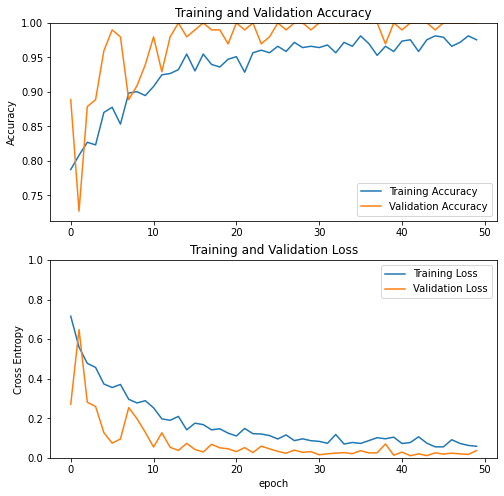

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

2 : 99.99899864196777


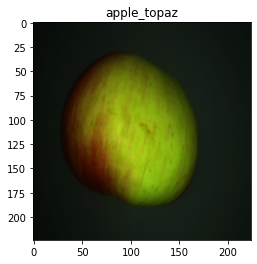

3 : 97.47354984283447


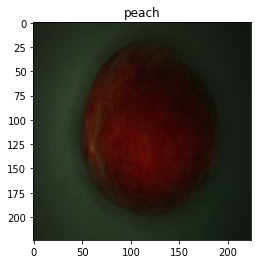

0 : 99.93578791618347


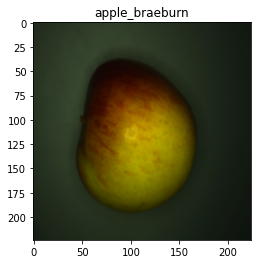

4 : 99.96557235717773


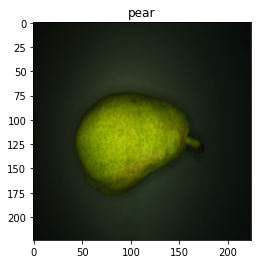

3 : 88.4938657283783


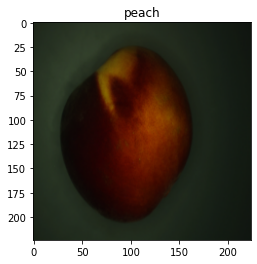

3 : 99.90634322166443
3 : 99.94227886199951
3 : 99.4763731956482
4 : 99.9765932559967
2 : 99.97653365135193
0 : 99.99788999557495
4 : 99.99914169311523
1 : 99.96341466903687
3 : 99.42052960395813
2 : 99.994957447052
3 : 99.84788298606873
4 : 99.99994039535522
4 : 99.99312162399292
2 : 98.77917170524597
3 : 99.99386072158813
1 : 99.62701797485352
3 : 99.96627569198608
1 : 99.90382194519043
4 : 99.89400506019592
4 : 99.9855637550354
0 : 99.980229139328
3 : 99.48285222053528
3 : 96.26626968383789
4 : 99.99605417251587
3 : 96.87547087669373
1 : 99.11243319511414
1 : 87.48040199279785
1 : 99.98940229415894
1 : 99.96908903121948
2 : 99.94279742240906
0 : 99.99871253967285
4 : 99.54525828361511
1 : 99.97252821922302
1 : 99.60363507270813
3 : 77.77010798454285
3 : 99.07183051109314
1 : 99.87021684646606
4 : 99.99092817306519
3 : 99.13588762283325
4 : 99.9882459640503
1 : 99.77080821990967
4 : 99.99741315841675
1 : 99.9657392501831
1 : 99.98643398284912
1 : 99.9862551689148
4 : 99.9999642372131

In [28]:
#テストデータセットから画像とラベルを取得
all_labels = np.ndarray(0)
all_preds = np.ndarray(0)

num_set=tf.data.experimental.cardinality(test_dataset)

iterator = iter(test_dataset)
for p in range(0, num_set):
    dset = iterator.get_next()
    #print(p, ":",dset[1])
    image_batch=dset[0]
    label_batch=dset[1]
    
    for i in range(0, len(image_batch)):#.as_numpy_iterator():#データセットはバッチサイズを1単位としてラベルと画像が入っているので、.take(1)とすると1つ目のバッチを取り出すことになる
        #print(image_batch[i].shape)
        
        preds=model(tf.reshape(image_batch[i],[-1,IMG_SHAPE[0],IMG_SHAPE[1],IMG_SHAPE[2]]))

        pred_class_id=np.argmax(preds)
        gt_class_id=np.argmax(label_batch[i])
        
        confi_arr=preds.numpy()[0]
        #print(confi_arr, pred_class_id)
        confi=confi_arr[pred_class_id]
        print(pred_class_id,":",confi*100)
        
        all_preds=np.append(all_preds,pred_class_id)
        all_labels=np.append(all_labels,gt_class_id)
        
        if(p==0 and i<5):
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            class_id=np.argmax(label_batch[i])
            plt.title(class_names[pred_class_id])
            plt.pause(0.001)

In [29]:
test_accuracy = tf.keras.metrics.Accuracy()
test_accuracy(all_preds, all_labels)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 99.219%


In [30]:
model.save("FruitsSorter2Category"+BASE_MODEL+".tf")

2021-11-10 01:46:22.696001: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: FruitsSorter2CategoryVGG16.tf/assets


In [ ]:
#RESET KERNEL to release memory on GPU!